**Step 1 : Clone yolov5 repository**

In [1]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15639, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 15639 (delta 121), reused 145 (delta 72), pack-reused 15393
Receiving objects: 100% (15639/15639), 14.65 MiB | 11.70 MiB/s, done.
Resolving deltas: 100% (10645/10645), done.


**Step 2: Change Directory to yolov5**

In [4]:
%cd yolov5/

/workplace/OpticalRemoteSensingClassification/yolov5


**Step 3: Install Dependencies**

In [3]:
!pip install -U -r requirements.txt

In [4]:
from google.colab import drive 
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
!unzip  "/workplace/OpticalRemoteSensingClassification/ShipRSImageNet_V1_resized.zip" -d training_data

Archive:  /workplace/OpticalRemoteSensingClassification/ShipRSImageNet_V1_resized.zip
   creating: training_data/ShipRSImageNet_V1/
   creating: training_data/ShipRSImageNet_V1/COCO_Format/
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipImageNet_train_bnbox_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_1.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_2.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_3.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_1.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_2.json  
  inflating: training_data/Ship

In [5]:
import random
random.seed(108)
import torch
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm
from random import choice
import shutil

In [6]:
def extract_from_xml(xml_file):
    # print(xml_file)
    root = ET.parse(xml_file).getroot()
    # Initialise the dict 
    dict = {}
    dict['bboxes'] = []
    dict['new_width'] = 512
    dict['new_height'] = 512

    # Parse the XML Tree
    for elem in root:
        if os.path.exists(xml_file):
          # Get the file name 
          if elem.tag == "filename":
              dict['filename'] = elem.text

          # Get the image size
          elif elem.tag == "size":
              image_size = []
              for subelem in elem:
                if subelem.tag == "width":
                  dict['old_width']=int(subelem.text)
                  image_size.append(dict['new_width'])
                elif subelem.tag == "height":
                  dict['old_height']=int(subelem.text)
                  image_size.append(dict['new_height'])
                elif subelem.tag == "depth":
                  image_size.append(int(subelem.text))
              dict['image_size'] = tuple(image_size)
          
          
          # Get details of the bounding box 
          elif elem.tag == "object":
              bbox = {}
              for subelem in elem:
                  if subelem.tag == "name":
                       bbox["class"] = subelem.text
                      
                  elif subelem.tag == "bndbox":
                      for subsubelem in subelem:
                        if subsubelem.tag == 'xmin' or subsubelem.tag == 'xmax':
                          bbox[subsubelem.tag] = (int(subsubelem.text) * dict['new_width'])/ dict['old_width']
                        elif subsubelem.tag == 'ymin' or subsubelem.tag == 'ymax':
                          bbox[subsubelem.tag] = (int(subsubelem.text) * dict['new_height'])/ dict['old_height']           
              dict['bboxes'].append(bbox)
        else:
            break
    return dict
print(extract_from_xml('training_data/ShipRSImageNet_V1/VOC_Format/Annotations/000160.xml'))
# print(extract_from_xml('training_data/ShipRSImageNet_V1/VOC_Format/Annotations/*'))

{'bboxes': [{'class': 'Submarine', 'xmin': 133.78064516129032, 'ymin': 145.89247311827958, 'xmax': 338.5806451612903, 'ymax': 356.1978494623656}, {'class': 'Submarine', 'xmin': 175.6215053763441, 'ymin': 121.11827956989248, 'xmax': 384.8258064516129, 'ymax': 330.3225806451613}], 'new_width': 512, 'new_height': 512, 'filename': '000160.bmp', 'old_width': 930, 'old_height': 930, 'image_size': (512, 512, 3)}


In [7]:
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "xml"]
annotations.sort()

# extract from xml file
for ann in tqdm(annotations):
    dict = extract_from_xml(ann)
    # print(dict)

100%|██████████| 2748/2748 [00:00<00:00, 3324.92it/s]


In [8]:
# Convert the info dict to the yolo format and write it to colab
def convert_to_yolov5(dict):
    print_buffer = []
    
    # For each bounding box
    for b in dict["bboxes"]:\
        
        # Transform the bbox co-ordinates as per YOLOv5 format
        xc = (b["xmin"] + b["xmax"]) / 2 
        yc = (b["ymin"] + b["ymax"]) / 2
        w  = (b["xmax"] - b["xmin"])
        h  = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates
        image_w, image_h, image_c = dict["image_size"]  
        xc /= image_w 
        yc /= image_h 
        w  /= image_w 
        h  /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(0, xc, yc, w, h))
        
    # Name of the file which we have to save 
    save_name = os.path.join("training_data/ShipRSImageNet_V1/VOC_Format/Annotations", dict["filename"].replace("bmp", "txt"))
    # print(save_file_name)
    # Save the annotation to colab
    print("\n".join(print_buffer), file= open(save_name, "w"))

In [9]:
# Get the annotations
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "xml"]
annotations.sort()
# Convert and save the annotations
for ann in tqdm(annotations):
    dict = extract_from_xml(ann)
    # print(dict)
    convert_to_yolov5(dict)
    os.remove(ann)
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "txt"]

100%|██████████| 2748/2748 [00:01<00:00, 1857.41it/s]


In [10]:
!mkdir dataset
path='./dataset/images/'
os.mkdir(path)
os.mkdir(path+'train')
os.mkdir(path+'val')
os.mkdir(path+'test')
path='./dataset/annotations/'
os.mkdir(path)
os.mkdir(path+'train')
os.mkdir(path+'val')
os.mkdir(path+'test')
old_name = r"./dataset/annotations/"
new_name = r"./dataset/labels/"
os.rename(old_name, new_name)

In [11]:
#path where annotations are stored 
path='./training_data/ShipRSImageNet_V1/VOC_Format/Annotations/'
count = len(os.listdir(path))
print(count)

array_imgs=[]
array_labels=[]
for (dirname, dirs, files) in os.walk(path):
    for filename in files:
        array_labels.append(filename)
        imgname=os.path.splitext(filename)[0]+'.bmp'
        array_imgs.append(imgname)

# 80% dataset is used for training and 20% for testing
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

#counting range for cycles
countTrain = int(len(array_imgs)*train_ratio)
countVal = int(len(array_labels)*val_ratio)
countTest = int(len(array_labels)*test_ratio)
print("training images are : ",countTrain)
print("Validation images are : ",countVal)
print("Test images are : ",countTest)

2748
training images are :  1923
Validation images are :  549
Test images are :  274


In [12]:
trainImgPath = './dataset/images/train'
trainlabelPath = './dataset/labels/train'
valImgPath = './dataset/images/val'
vallabelPath = './dataset/labels/val'
testImgPath = './dataset/images/test'
testlabelPath = './dataset/labels/test'
imgPath='./training_data/ShipRSImageNet_V1/VOC_Format/cloudy/'


#loop for train
for x in range(int(countTrain)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(trainImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(trainlabelPath, fileXml))

    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

#loop for val   
for x in range(int(countVal)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(valImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(vallabelPath, fileXml))
    
    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

#loop for test   
for x in range(int(countTest)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(testImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(testlabelPath, fileXml))
    
    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

In [13]:
# Create .yaml file 
import yaml

data_yaml = {
    'train' : f'./dataset/images/train',
    'val' : f'./dataset/images/val',
    'test' : f'./dataset/images/test',
    'nc' : 1,
    'names' : ['ship']
}

    # Note that I am creating the file in the yolov5/data/ directory.
with open(f'./data/ship_detect.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

%cat data/ship_detect.yaml

{names: [ship], nc: 1, test: ./dataset/images/test, train: ./dataset/images/train,
  val: ./dataset/images/val}


In [14]:
!python train.py --img 512 --batch 10 --epochs 100 --data ship_detect.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt --project yolov5_cloudy_detect --name yolov5_results --save-period 10 --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: navi71242 (navi12344). Use `wandb login --relogin` to force relogin
train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=ship_detect.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=10, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_cloudless_detect, name=yolov5_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=10, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v7.0-1

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

**Validation**

In [20]:
!python val.py --batch 10 --data ship_detect.yaml --weights 'yolov5_cloudy_detect/yolov5_results/weights/best.pt' --task test --project yolov5_cloudy_detect --name 'Validation' --augment

val: data=/workplace/OpticalRemoteSensingClassification/yolov5/data/ship_detect.yaml, weights=['yolov5_cloudy_detect/yolov5_results/weights/best.pt'], batch_size=10, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5_cloudy_detect, name=Validation, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-160-g867f7f0 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
test: Scanning /workplace/OpticalRemoteSensingClassification/yolov5/dataset/labe
                 Class     Images  Instances          P          R      mAP50   
                   all        274       1253      0.908      0.752      0.841      0.679
Speed: 0.4ms pre-process, 44.5ms inference, 0.7ms NMS per image at shape (10, 3, 640, 640)
Results s

**Run YOLO5 Inference on test images** 

In [5]:
!python detect.py --weights 'yolov5_cloudy_detect/yolov5_results/weights/best.pt' --img 512 --conf 0.4 --source ./dataset/images/test --iou 0.45 --augment --project 'yolov5_cloudy_detect' --name 'detect_test' --line-thickness 1

detect: weights=['yolov5_cloudy_detect/yolov5_results/weights/best.pt'], source=./dataset/images/test, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5_cloudy_detect, name=detect_test, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-160-g867f7f0 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
image 1/274 /workplace/OpticalRemoteSensingClassification/yolov5/dataset/images/test/000011.bmp: 512x512 11 ships, 109.4ms
image 2/274 /workplace/OpticalRemoteSensingClassification/yolov5/dataset/images/test/000050.bmp: 512x512 15 ships, 43.0ms
image 3/274 /workplace/OpticalRemoteSensingClass

In [6]:
!zip -r results_cloudy.zip yolov5_cloudy_detect

  adding: yolov5_cloudy_detect/ (stored 0%)
  adding: yolov5_cloudy_detect/yolov5_results/ (stored 0%)
  adding: yolov5_cloudy_detect/yolov5_results/weights/ (stored 0%)
  adding: yolov5_cloudy_detect/yolov5_results/weights/last.pt (deflated 8%)
  adding: yolov5_cloudy_detect/yolov5_results/weights/best.pt (deflated 8%)
  adding: yolov5_cloudy_detect/yolov5_results/hyp.yaml (deflated 45%)
  adding: yolov5_cloudy_detect/yolov5_results/opt.yaml (deflated 49%)
  adding: yolov5_cloudy_detect/yolov5_results/events.out.tfevents.1683019273.76f2ba8b81a9.372742.0 (deflated 58%)
  adding: yolov5_cloudy_detect/yolov5_results/labels_correlogram.jpg (deflated 33%)
  adding: yolov5_cloudy_detect/yolov5_results/labels.jpg (deflated 22%)
  adding: yolov5_cloudy_detect/yolov5_results/train_batch0.jpg (deflated 9%)
  adding: yolov5_cloudy_detect/yolov5_results/train_batch1.jpg (deflated 9%)
  adding: yolov5_cloudy_detect/yolov5_results/train_batch2.jpg (deflated 9%)
  adding: yolov5_cloudy_detect/yolov5

Step 5 : Display image in VS Code

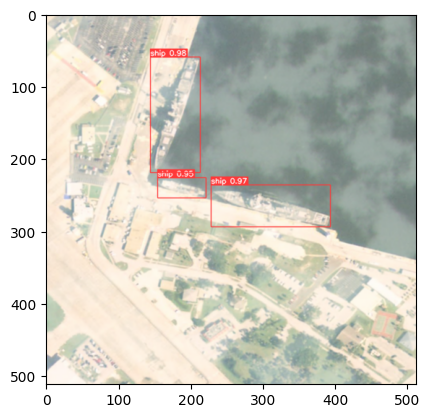

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = './yolov5_cloudy_detect/detect_test/000368.bmp'

# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

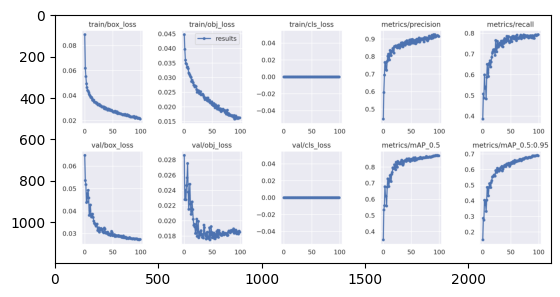

In [30]:
img_path = './yolov5_cloudy_detect/yolov5_results/results.png'

# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

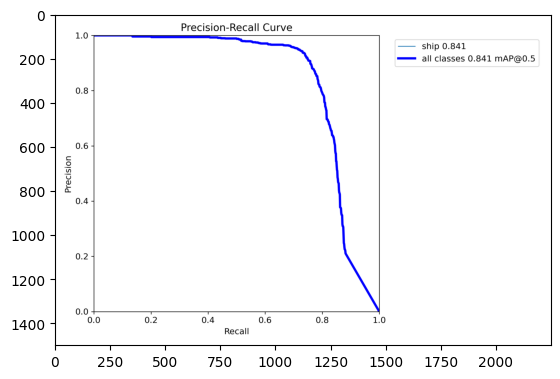

In [31]:
img_path = './yolov5_cloudy_detect/Validation/PR_curve.png'

# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

**Step 5: Display image in colab**

In [ ]:
# from google.colab.patches import cv2_imshow
# from skimage import io
# img_path='./yolov5_cloudy_detect/detect_test/000209.bmp'
# image=io.imread(img_path)
# cv2_imshow(image)

In [ ]:
# img_path='./yolov5_cloudy_detect/yolov5_results/results.png'
# image=io.imread(img_path)
# cv2_imshow(image)

In [ ]:
# img_path='./yolov5_cloudy_detect/Validation/PR_curve.png'
# image=io.imread(img_path)
# cv2_imshow(image)